Source code for question 1

In [7]:
import numpy as np
from PIL import Image
import math
from copy import copy, deepcopy
from matplotlib import pyplot as plt
import matplotlib

In [8]:
def x_y_resize(image, factor_x, factor_y, inter="BL", offset_x = 0, offset_y = 0, debug = False):
    """
    resize 'image' height by 'factor_x' and its width by 'factor_y'
    offset the output by offset_x and offset_y
    use inter as interpolation method
    """
    height = image.shape[0]
    width = image.shape[1]
    new_height = int(image.shape[0] * factor_y)
    new_width = int(image.shape[1] * factor_x)
    base = np.zeros((new_height, new_width, image.shape[2]))
    base_height = new_height
    base_width = new_width
    if inter == "NN":
        for row in range(new_height + 1):
            for col in range(new_width + 1):
                original_point = [row / factor_y, col / factor_x]
                temp_0 = [math.floor(original_point[0]), math.ceil(original_point[0])]
                temp_1 = [math.floor(original_point[1]), math.ceil(original_point[1])]
                original_point[0] = temp_0[1] if original_point[0] - temp_0[0] >= 0.5 else temp_0[0]
                original_point[1] = temp_1[1] if original_point[1] - temp_1[0] >= 0.5 else temp_1[0]
                if 0 <= (original_point[0] - 1) < height and 0 <= (original_point[1] - 1) < width and row + offset_y < base_height and col + offset_x < base_width:
                    if debug:
                        print("for row = ", row, " and col = ", col, " x = ", original_point[1] - 1, " y = ", original_point[0] - 1)
                    base[row + offset_y, col + offset_x, :] = image[int(original_point[0]) - 1, int(original_point[1]) - 1, :]
    elif inter == "BL":
        for row in range(new_height + 1):
            for col in range(new_width + 1):
                original_point = [row / factor_y, col / factor_x]
                original_y = int(math.floor(original_point[0]))
                original_x = int(math.floor(original_point[1]))
                ratio_y = original_point[0] - original_y
                ratio_x = original_point[1] - original_x
                has_zeroed = False
                if row + offset_y < base_height and col + offset_x < base_width:
                    original_x -= 1
                    original_y -= 1
                    if 0 <= original_y < height and 0 <= original_x < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x, " y = ", original_y)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((1 - ratio_y) * (1 - ratio_x) * image[original_y, original_x, :]).astype(np.uint8)
                    if 0 <= original_y < height and 0 <= original_x + 1 < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x + 1, " y = ", original_y)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((1 - ratio_y) * (ratio_x) * image[original_y, original_x + 1, :]).astype(np.uint8)
                    if 0 <= original_y + 1 < height and 0 <= original_x < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x, " y = ", original_y + 1)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((ratio_y) * (1 - ratio_x) * image[original_y + 1, original_x, :]).astype(np.uint8)
                    if 0 <= original_y + 1 < height and 0 <= original_x + 1 < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x + 1, " y = ", original_y + 1)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((ratio_y) * (ratio_x) * image[original_y + 1, original_x + 1, :]).astype(np.uint8)
    return base

In [9]:
def register_image(base, image, r_x, r_y, angle, offset_x = -1, offset_y = -1, mangle_alpha=False, mangle_ratio=2, debug=False):
    """
    register 'image' on 'base' by 'angle' degree rotation
    offset the output by offset_x and offset_y
    """
    if r_x != 1 or r_y != 1:
        image = x_y_resize(image, r_x, r_y)
    #We need to convert angle from degrees to radians to be able to do math on it!
    angle=math.radians(angle)
    #We need to know cos and sin of that angle to be able to calculate rotated image by performing the transform
    cosine = math.cos(angle)
    sine = math.sin(angle)
    #Now we construct rotation matrix and its invers
    rotation_matrix = [
        [cosine, sine],
        [-sine, cosine]
    ]
    rotation_matrix = np.array(rotation_matrix)
    inv_matrix = np.linalg.inv(rotation_matrix)
    if debug:
        print(rotation_matrix)
        print(inv_matrix)
    height = image.shape[0]
    width = image.shape[1]

    base_height = base.shape[0]
    base_width  = base.shape[1]
    rotation_center_x = round(width / 2.0)
    rotation_center_y = round(height / 2.0)
    new_height  = math.floor(abs(height * cosine) + abs(width * sine))
    new_width  = math.floor(abs(width * cosine) + abs(height * sine))
    dest_center_x = round(new_width / 2.0)
    dest_center_y = round(new_height / 2.0)

    for row in range(new_height + 1):
        for col in range(new_width + 1):
            original_point = inv_matrix.dot([(row - dest_center_y), (col - dest_center_x)])
            original_point[0] += rotation_center_y
            original_point[1] += rotation_center_x
            temp_0 = [math.floor(original_point[0]), math.ceil(original_point[0])]
            temp_1 = [math.floor(original_point[1]), math.ceil(original_point[1])]
            original_point[0] = temp_0[1] if original_point[0] - temp_0[0] >= 0.5 else temp_0[0]
            original_point[1] = temp_1[1] if original_point[1] - temp_1[0] >= 0.5 else temp_1[0]
            if 0 <= (original_point[0] - 1) < height and 0 <= (original_point[1] - 1) < width and row + offset_y < base_height and col + offset_x < base_width:
                if debug:
                    print("for row = ", row, " and col = ", col, " x = ", original_point[1] - 1, " y = ", original_point[0] - 1)
                if mangle_alpha:
                    # base[row + offset_y, col + offset_x, 3] = 0
                    alpha_img = image[int(original_point[0]) - 1, int(original_point[1]) - 1, 3]
                    alpha_base = base[row + offset_y, col + offset_x, 3]
                    alpha_sum = int(int(alpha_img) + int(alpha_base))
                    alpha_ratio = (alpha_img) / (alpha_sum)
                    base[row + offset_y, col + offset_x, :3] = image[int(original_point[0]) - 1, int(original_point[1]) - 1, :3] * alpha_ratio + base[row + offset_y, col + offset_x, :3] * (1 - alpha_ratio)
                else:
                    base[row + offset_y, col + offset_x, :] = image[int(original_point[0]) - 1, int(original_point[1]) - 1, :]
    return base


[]

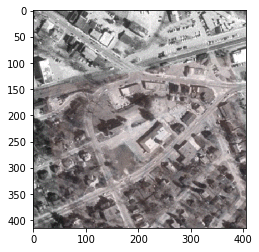

In [5]:
map1 = matplotlib.pyplot.imread("Map1.gif")
map2 = matplotlib.pyplot.imread("Map2.gif")

base =  np.zeros((500, 500, 4))
map1[:, :, 3] = 255

map2[:, :, 3] = 55
base = register_image(map1, map2, 1, 1, -9.8, offset_x=13, offset_y=85, mangle_alpha=True)
base[:, :, 3] = 255

matplotlib.pyplot.imshow(base)
matplotlib.pyplot.plot()

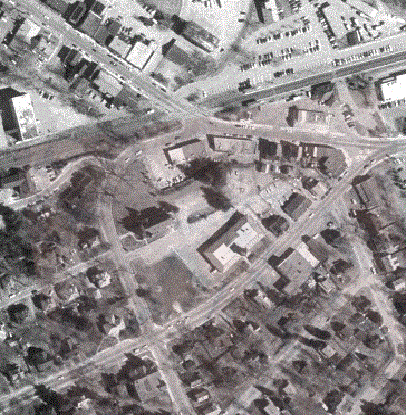

In [14]:
def extract_image(image, name="res"):
    pil_img=Image.fromarray((image).astype(np.uint8))
    pil_img.save("./" + str(name) +  ".png")
    return pil_img
map1 = matplotlib.pyplot.imread("Map1.gif")
map2 = matplotlib.pyplot.imread("Map2.gif")

base =  np.zeros((500, 500, 4))
map1[:, :, 3] = 255

map2[:, :, 3] = 55
base = register_image(map1, map2, 1, 1, -9.8, offset_x=13, offset_y=85, mangle_alpha=True)
base[:, :, 3] = 255
extract_image(base, "registration")

In [10]:
def rotate_image(base, image, r_x, r_y, angle, offset_x = -1, offset_y = -1, inter="NN", debug=False):
    base = deepcopy(base)
    if r_x != 1 or r_y != 1:
        image = x_y_resize(image, r_x, r_y)
    #We need to convert angle from degrees to radians to be able to do math on it!
    angle=math.radians(angle)
    #We need to know cos and sin of that angle to be able to calculate rotated image by performing the transform
    cosine = math.cos(angle)
    sine = math.sin(angle)
    #Now we construct rotation matrix and its invers
    rotation_matrix = [
        [cosine, sine],
        [-sine, cosine]
    ]
    rotation_matrix = np.array(rotation_matrix)
    inv_matrix = np.linalg.inv(rotation_matrix)
    if debug:
        print(rotation_matrix)
        print(inv_matrix)
    height = image.shape[0]
    width = image.shape[1]

    base_height = base.shape[0]
    base_width  = base.shape[1]
    rotation_center_x = round(width / 2.0)
    rotation_center_y = round(height / 2.0)
    new_height  = math.floor(abs(height * cosine) + abs(width * sine))
    new_width  = math.floor(abs(width * cosine) + abs(height * sine))
    dest_center_x = round(new_width / 2.0)
    dest_center_y = round(new_height / 2.0)

    if inter == "NN":
        for row in range(new_height + 1):
            for col in range(new_width + 1):
                original_point = inv_matrix.dot([(row - dest_center_y), (col - dest_center_x)])
                original_point[0] += rotation_center_y
                original_point[1] += rotation_center_x
                temp_0 = [math.floor(original_point[0]), math.ceil(original_point[0])]
                temp_1 = [math.floor(original_point[1]), math.ceil(original_point[1])]
                original_point[0] = temp_0[1] if original_point[0] - temp_0[0] >= 0.5 else temp_0[0]
                original_point[1] = temp_1[1] if original_point[1] - temp_1[0] >= 0.5 else temp_1[0]
                if 0 <= (original_point[0] - 1) < height and 0 <= (original_point[1] - 1) < width and row + offset_y < base_height and col + offset_x < base_width:
                    if debug:
                        print("for row = ", row, " and col = ", col, " x = ", original_point[1] - 1, " y = ", original_point[0] - 1)
                    base[row + offset_y, col + offset_x, :] = image[int(original_point[0]) - 1, int(original_point[1]) - 1, :]
    elif inter == "BL":
        for row in range(new_height + 1):
            for col in range(new_width + 1):
                original_point = inv_matrix.dot([(row - dest_center_y), (col - dest_center_x)])
                original_point[0] += rotation_center_y
                original_point[1] += rotation_center_x
                original_y = int(math.floor(original_point[0]))
                original_x = int(math.floor(original_point[1]))
                ratio_y = original_point[0] - original_y
                ratio_x = original_point[1] - original_x
                has_zeroed = False
                if row + offset_y < base_height and col + offset_x < base_width:
                    original_x -= 1
                    original_y -= 1
                    if 0 <= original_y < height and 0 <= original_x < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x, " y = ", original_y)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((1 - ratio_y) * (1 - ratio_x) * image[original_y, original_x, :]).astype(np.uint8)
                    if 0 <= original_y < height and 0 <= original_x + 1 < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x + 1, " y = ", original_y)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((1 - ratio_y) * (ratio_x) * image[original_y, original_x + 1, :]).astype(np.uint8)
                    if 0 <= original_y + 1 < height and 0 <= original_x < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x, " y = ", original_y + 1)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((ratio_y) * (1 - ratio_x) * image[original_y + 1, original_x, :]).astype(np.uint8)
                    if 0 <= original_y + 1 < height and 0 <= original_x + 1 < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x + 1, " y = ", original_y + 1)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((ratio_y) * (ratio_x) * image[original_y + 1, original_x + 1, :]).astype(np.uint8)
    return base

In [11]:
def shear_image(base, image, r_x, r_y, angle, offset_x = -1, offset_y = -1, inter="NN", parallel_to="X", debug=False):
    base = deepcopy(base)
    if r_x != 1 or r_y != 1:
        image = x_y_resize(image, r_x, r_y)
    #We need to convert angle from degrees to radians to be able to do math on it!
    angle=math.radians(angle)
    #We need to know cos and sin of that angle to be able to calculate rotated image by performing the transform
    tan = math.tan(angle)
    #Now we construct rotation matrix and its invers
    if parallel_to == "X":
        shear_matrix = [
            [1, tan],
            [0,   1]
        ]
    elif parallel_to == "Y":
        shear_matrix = [
            [1,   0],
            [tan, 1]
        ]
    shear_matrix = np.array(shear_matrix)
    inv_matrix = np.linalg.inv(shear_matrix)
    if debug:
        print(rotation_matrix)
        print(inv_matrix)
    height = image.shape[0]
    width = image.shape[1]

    base_height = base.shape[0]
    base_width  = base.shape[1]
    rotation_center_x = round(width / 2.0)
    rotation_center_y = round(height / 2.0)
    temp = shear_matrix.dot([height, width])
    new_height  = math.floor(temp[0])
    new_width  = math.floor(temp[1])
    dest_center_x = round(new_width / 2.0)
    dest_center_y = round(new_height / 2.0)

    if inter == "NN":
        for row in range(new_height + 1):
            for col in range(new_width + 1):
                original_point = inv_matrix.dot([(row - dest_center_y), (col - dest_center_x)])
                original_point[0] += rotation_center_y
                original_point[1] += rotation_center_x
                temp_0 = [math.floor(original_point[0]), math.ceil(original_point[0])]
                temp_1 = [math.floor(original_point[1]), math.ceil(original_point[1])]
                original_point[0] = temp_0[1] if original_point[0] - temp_0[0] >= 0.5 else temp_0[0]
                original_point[1] = temp_1[1] if original_point[1] - temp_1[0] >= 0.5 else temp_1[0]
                if 0 <= (original_point[0] - 1) < height and 0 <= (original_point[1] - 1) < width and row + offset_y < base_height and col + offset_x < base_width:
                    if debug:
                        print("for row = ", row, " and col = ", col, " x = ", original_point[1] - 1, " y = ", original_point[0] - 1)
                    base[row + offset_y, col + offset_x, :] = image[int(original_point[0]) - 1, int(original_point[1]) - 1, :]
    elif inter == "BL":
        for row in range(new_height + 1):
            for col in range(new_width + 1):
                original_point = inv_matrix.dot([(row - dest_center_y), (col - dest_center_x)])
                original_point[0] += rotation_center_y
                original_point[1] += rotation_center_x
                original_y = int(math.floor(original_point[0]))
                original_x = int(math.floor(original_point[1]))
                ratio_y = original_point[0] - original_y
                ratio_x = original_point[1] - original_x
                has_zeroed = False
                if row + offset_y < base_height and col + offset_x < base_width:
                    original_x -= 1
                    original_y -= 1
                    if 0 <= original_y < height and 0 <= original_x < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x, " y = ", original_y)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((1 - ratio_y) * (1 - ratio_x) * image[original_y, original_x, :]).astype(np.uint8)
                    if 0 <= original_y < height and 0 <= original_x + 1 < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x + 1, " y = ", original_y)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((1 - ratio_y) * (ratio_x) * image[original_y, original_x + 1, :]).astype(np.uint8)
                    if 0 <= original_y + 1 < height and 0 <= original_x < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x, " y = ", original_y + 1)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((ratio_y) * (1 - ratio_x) * image[original_y + 1, original_x, :]).astype(np.uint8)
                    if 0 <= original_y + 1 < height and 0 <= original_x + 1 < width :
                        if debug:
                            print("for row = ", row + offset_y, " and col = ", col + offset_x, " x = ", original_x + 1, " y = ", original_y + 1)
                        if not has_zeroed:
                            base[row + offset_y, col + offset_x, :] = np.zeros(image.shape[2])
                            has_zeroed = True
                        base[row + offset_y, col + offset_x, :] += ((ratio_y) * (ratio_x) * image[original_y + 1, original_x + 1, :]).astype(np.uint8)
    return base

[]

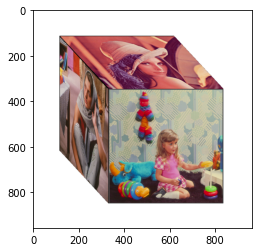

In [30]:
cube = Image.open("./Cube.png")
cube = np.array(cube)
lena = Image.open("./lena.bmp")
lena = np.array(lena)
kiddo = Image.open("./girl.bmp")
kiddo = np.array(kiddo)
lady = Image.open("./barbara.bmp")
lady = np.array(lady)

res = rotate_image(cube, kiddo, 0.98, 0.98, 0, offset_x= 330, offset_y= 345, inter="BL", debug=False)

res = shear_image(res, lena, 0.98, 0.455, 43, offset_x = 116, offset_y= 113, inter="BL", parallel_to="Y", debug=False)

res = shear_image(res, lady, 0.417, 0.98, 47.347, offset_x = 116, offset_y= 113, inter="BL", parallel_to="X", debug=False)
matplotlib.pyplot.imshow(res)
matplotlib.pyplot.plot()

[]

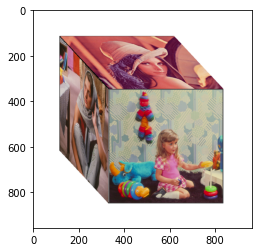

In [13]:
cube = Image.open("./Cube.png")
cube = np.array(cube)
lena = Image.open("./lena.bmp")
lena = np.array(lena)
kiddo = Image.open("./girl.bmp")
kiddo = np.array(kiddo)
lady = Image.open("./barbara.bmp")
lady = np.array(lady)
def extract_image(image, name="res"):
    pil_img=Image.fromarray((image).astype(np.uint8))
    pil_img.save("./" + str(name) +  ".png")
    return pil_img

res = rotate_image(cube, kiddo, 0.98, 0.98, 0, offset_x= 330, offset_y= 345, inter="NN", debug=False)

res = shear_image(res, lena, 0.98, 0.455, 43, offset_x = 116, offset_y= 113, inter="NN", parallel_to="Y", debug=False)

res = shear_image(res, lady, 0.417, 0.98, 47.347, offset_x = 116, offset_y= 113, inter="NN", parallel_to="X", debug=False)
extract_image(res, "cube_nn")
matplotlib.pyplot.imshow(res)
matplotlib.pyplot.plot()